<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s4e02/undraw_Coding_re_iv62.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S4E02 - Prediction of Obesity Risk</p>

<center>
<table style="
  padding: 10px;
  font-family: 'JetBrains Mono';
  font-size: 16px;
  width: 100%";
>
  <tr>
    <th>Version</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>V1</td>
    <td>Section 1. Quick Overview</td>
  </tr>
</table>
</center>

In [68]:
# %load ../utils/config.py
import collections
import functools
import glob
import itertools
import operator
import os
import pathlib
import shutil
import subprocess
import sys
import time
import warnings
from array import array
from copy import copy

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.display import HTML, Image, display_html
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Data Frame and Plotly colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"
GRADIENT_COLOR = "#BAB8B8"
# Define as numpy array because it supports fancy indexing.
COLOR_SCHEME = np.array(("#4A4B52", "#780D0D", "#2D3142"))
# Ticks size for plotly and matplotlib.
TICKSIZE = 11

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_family="Open Sans",
        font_color=FONT_COLOR,
        title_font_size=20,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        yaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        width=840,
        height=540,
        legend=dict(x=1, y=1, yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 14,
    "axes.grid": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 14,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    "font.family": "Serif",
}
sns.set_theme(rc=MATPLOTLIB_THEME)

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `None`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    if data_dir is None:
        data_dir = pathlib.Path("data/")
    else:
        data_dir = pathlib.Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return [interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1)]


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99))
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    n_null = frame.isna().sum()
    n_null_percent = n_null / len(frame) * 100.0
    n_unique = frame.apply(lambda col: len(col.dropna().unique()))
    mode_count = frame.apply(lambda col: col.value_counts().iloc[0])
    mode = frame.mode().iloc[:1].T.squeeze()
    n_unique_percent = n_unique / len(frame) * 100.0
    mode_percent_count = mode_count / len(frame) * 100.0

    return pd.DataFrame(
        {
            "dtype": frame.dtypes,
            "n_null": n_null,
            "n_null_percent": n_null_percent,
            "n_unique": n_unique,
            "n_unique_percent": n_unique_percent,
            "mode": mode,
            "mode_count": mode_count,
            "mode_percent_count": mode_percent_count,
        }
    )


def check_categories_alignment(frame1, frame2, /, out_color=BLUE):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = frame2.select_dtypes(include=["object", "category"]).columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].dropna().unique())
        frame2_unique = set(frame2[feature].dropna().unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:30s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
    if img_dir is None:
        img_dir = pathlib.Path("images")
    else:
        img_dir = pathlib.Path(img_dir)

    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)

    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(itertools.product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


def unit_norm(x):
    return x / np.sum(x)


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster"><b>Obesity or CVD Risk</b></a>. Feature distributions are close to, but not exactly the same, as the original. Full description of the original dataset is as follows.:<br><br>
    <i>The data consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition, data was collected using a web platform with a survey where anonymous users answered each question, then the information was processed obtaining 17 attributes and 2111 records. The records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III. 77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was collected directly from users through a web platform.</i><br><br>
    <b>Original paper: <a href="https://www.researchgate.net/publication/334888106_Dataset_for_estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition_in_individuals_from_Colombia_Peru_and_Mexico">Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico</a></b>
    
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This is a multi-class classification problem, where the main task is to predict category of the <code>NObeyesdad</code> feature. The competition evaluation metric is <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision"><b>Accuracy</b></a>:
    \[\textrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN},\]
    where <i>TP</i> - true positive, <i>TN</i> - true negative, <i>FP</i> - false positive, <i>FN</i> - false negative,
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #780D0D;
    border-radius: 2px;
    border: 1px solid #780D0D;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#data_reading_and_features_description"><span style="color: #F2F2F0">Data Reading &amp; Features Description</span></a></li>
            <li><a href="#basic_numerical_properties_summaries"><span style="color: #F2F2F0">Basic Numerical Properties &amp; Summaries</span></a></li>
            <li><a href="#playing_with_categorical_variables"><span style="color: #F2F2F0">Playing with Categorical Variables</span></a></li>
            <li><a href="#probability_plots_and_example_transformations"><span style="color: #F2F2F0">Probability Plots &amp; Example Transformations</span></a></li>
            <li><a href="#bmi_is_not_sufficient_due_to_its_synthetic_nature"><span style="color: #F2F2F0">BMI is not Sufficient due to its Synthetic Nature</span></a></li>
        </ol>
    </li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, I provide a quick overview of the dataset. This way we find out a little about the data. More detailed analysis will be done in subsequent sections.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [69]:
competition = "playground-series-s4e2"
competition_dataset = f"kaggle competitions download -c {competition}"

orig_data = "obesity-or-cvd-risk-classifyregressorcluster"
orig_user = "aravindpcoder"
original_dataset = f"kaggle datasets download -d {orig_user}/{orig_data}"

if not ON_KAGGLE:
    download_from_kaggle(competition_dataset)
    download_from_kaggle(original_dataset)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
    orig_path = "data/ObesityDataSet.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    orig_path = f"/kaggle/input/{orig_data}/ObesityDataSet.csv"

train = pd.read_csv(train_path, index_col="id")  # .rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id")  # .rename(columns=str.title)
orig = pd.read_csv(orig_path)[train.columns]  # .rename(columns=str.title)

In [70]:
get_pretty_frame(orig.head())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000,1.620,64.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,0.000,1.000,no,Public_Transportation,Normal_Weight
1,Female,21.000,1.520,56.000,yes,no,3.000,3.000,Sometimes,yes,3.000,yes,3.000,0.000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000,1.800,77.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,2.000,1.000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000,1.800,87.000,no,no,3.000,3.000,Sometimes,no,2.000,no,2.000,0.000,Frequently,Walking,Overweight_Level_I
4,Male,22.000,1.780,89.800,no,no,2.000,1.000,Sometimes,no,2.000,no,0.000,0.000,Sometimes,Public_Transportation,Overweight_Level_II


In [71]:
orig.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Columns: 17 entries, Gender to NObeyesdad
dtypes: float64(8), object(9)
memory usage: 280.5+ KB


In [72]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Columns: 17 entries, Gender to NObeyesdad
dtypes: float64(8), object(9)
memory usage: 2.9+ MB


In [73]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 13840 entries, 20758 to 34597
Columns: 16 entries, Gender to MTRANS
dtypes: float64(8), object(8)
memory usage: 1.8+ MB


<p style="  
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
  <b>Features Description</b> 📔
</p>

<center>
<table style="
  padding: 10px;
  border-radius: 2px;
  border: 4px solid #4A4B52;
  font-family: 'JetBrains Mono';
  font-size: 16px;
  width: 100%";
>
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Gender</td>
    <td>Person gender.</td>
  </tr>
  <tr>
    <td>Age</td>
    <td>Person age.</td>
  </tr>
  <tr>
    <td>Height</td>
    <td>Person height (in meters).</td>
  </tr>
  <tr>
    <td>Weight</td>
    <td>Person weight (in kilograms).</td>
  </tr>
  <tr>
    <td>family_history_with_overweight</td>
    <td>Whether a family member suffered or suffers from overweight.</td>
  </tr>
  <tr>
    <td>FAVC</td>
    <td>Frequent consumption of a high caloric food.</td>
  </tr>
  <tr>
    <td>FCVC</td>
    <td>Frequency of consumption of vegetables.</td>
  </tr>
  <tr>
    <td>NCP</td>
    <td>Number of main meals daily.</td>
  </tr>
  <tr>
    <td>CAEC</td>
    <td>Consumption of food between meals.</td>
  </tr>
  <tr>
    <td>SMOKE</td>
    <td>Whether a person is smoker or not.</td>
  </tr>
  <tr>
    <td>CH2O</td>
    <td>Consumption of water daily.</td>
  </tr>
  <tr>
    <td>SCC</td>
    <td>Calories consumption monitoring.</td>
  </tr>
  <tr>
    <td>FAF</td>
    <td>Physical activity frequency (weekly).</td>
  </tr>
  <tr>
    <td>TUE</td>
    <td>Time using technology devices (daily).</td>
  </tr>
  <tr>
    <td>CALC</td>
    <td>Consumption of alcohol.</td>
  </tr>
  <tr>
    <td>MTRANS</td>
    <td>Type of transportation used.</td>
  </tr>
  <tr>
    <td>NObeyesdad</td>
    <td>Obesity level deducted. These types are as follows (BMI indicator): Insufficient less than $18.5$, Normal $18.5$ to $24.9$, Overweight $25.0$ to $29.9$, Obesity I $30.0$ to $34.9$, Obesity II $35.0$ to $39.9$, Obesity III higher than $40$.</td>
  </tr>
</table>
</center>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, here we've got $16$ features where $8$ of them are categorical and $8$ are numerical. Nevertheless, in the original work only $3$ features are truly numerical. These are <code>Age</code>, <code>Height</code> and <code>Weight</code>. <b>The rest five numerical features were categorical indeed, but their continous nature results from using SMOTE.</b> You can read about this in the original paper. So, we have data generated from a deep learning model, which was trained in 77% on synthetic data. Wonderful! In the end, there are $20758$ samples in the training data and $13840$ in the test dataset. This gives $1297$ entries per dimension during training, so there should be enough data to learn patterns. Let's get to the basic numerical summaries.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

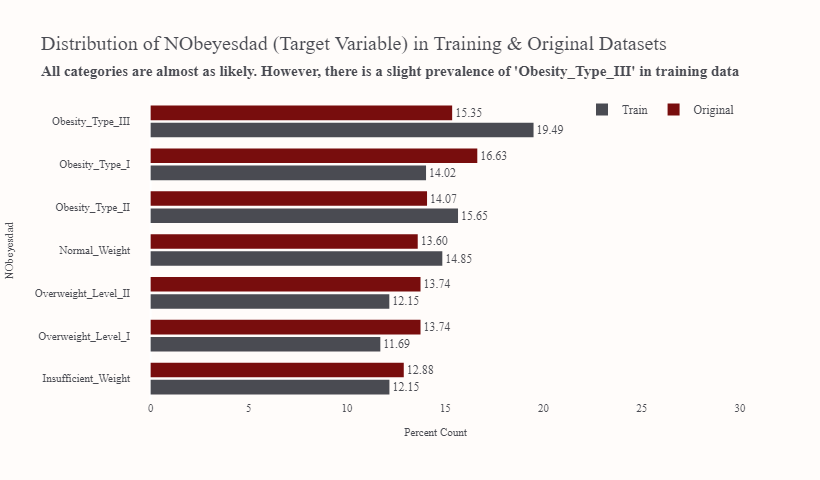

In [74]:
warnings.filterwarnings("ignore")

train_extended = pd.concat(
    (
        train.assign(Source="Train"),
        orig.assign(Source="Original")
    ),
    ignore_index=True,
)
train_extended = train_extended.sample(frac=1.0, random_state=42)

fig = px.histogram(
    train_extended,
    y="NObeyesdad",
    histnorm="percent",
    color="Source",
    color_discrete_sequence=COLOR_SCHEME,
    width=820,
    height=480,
    barmode="group",
    text_auto="0.2f",  # type: ignore
    orientation="h",
    title="Distribution of NObeyesdad (Target Variable) in Training & Original Datasets<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "All categories are almost as likely. However, there is a slight "
    "prevalence of 'Obesity_Type_III' in training data</span>",
)
fig.update_yaxes(title="NObeyesdad", categoryorder="total ascending")
fig.update_xaxes(title="Percent Count", range=(-1, 30))
fig.update_traces(textposition="outside")
fig.update_layout(bargap=0.2, bargroupgap=0.15, legend=dict(y=0.92, x=1.0, title=""))
save_and_show_fig(fig, "status_distribution")

In [75]:
print(CLR + "Original Dataset - General Summary:")
orig_summary = frame_summary(orig.drop(columns="NObeyesdad"))
get_pretty_frame(orig_summary, gradient=True)

Original Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
Gender,object,0,0.000,2,0.095,Male,1068,50.592
Age,float64,0,0.000,1402,66.414,18.000,128,6.063
Height,float64,0,0.000,1574,74.562,1.700,60,2.842
Weight,float64,0,0.000,1525,72.241,80.000,59,2.795
family_history_with_overweight,object,0,0.000,2,0.095,yes,1726,81.762
FAVC,object,0,0.000,2,0.095,yes,1866,88.394
FCVC,float64,0,0.000,810,38.370,3.000,652,30.886
NCP,float64,0,0.000,635,30.081,3.000,1203,56.987
CAEC,object,0,0.000,4,0.189,Sometimes,1765,83.610
SMOKE,object,0,0.000,2,0.095,no,2067,97.916


In [76]:
print(CLR + "Training Dataset - General Summary:")
train_summary = frame_summary(train.drop(columns="NObeyesdad"))
get_pretty_frame(train_summary, gradient=True)

Training Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
Gender,object,0,0.000,2,0.010,Female,10422,50.207
Age,float64,0,0.000,1703,8.204,18.000,1916,9.230
Height,float64,0,0.000,1833,8.830,1.700,1334,6.426
Weight,float64,0,0.000,1979,9.534,80.000,866,4.172
family_history_with_overweight,object,0,0.000,2,0.010,yes,17014,81.964
FAVC,object,0,0.000,2,0.010,yes,18982,91.444
FCVC,float64,0,0.000,934,4.499,3.000,7658,36.892
NCP,float64,0,0.000,689,3.319,3.000,14706,70.845
CAEC,object,0,0.000,4,0.019,Sometimes,17529,84.445
SMOKE,object,0,0.000,2,0.010,no,20513,98.820


In [77]:
print(CLR + "Test Dataset - General Summary:")
test_summary = frame_summary(test)
get_pretty_frame(test_summary, gradient=True)

Test Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
Gender,object,0,0.000,2,0.014,Female,6965,50.325
Age,float64,0,0.000,1539,11.120,18.000,1320,9.538
Height,float64,0,0.000,1739,12.565,1.700,847,6.120
Weight,float64,0,0.000,1798,12.991,80.000,631,4.559
family_history_with_overweight,object,0,0.000,2,0.014,yes,11384,82.254
FAVC,object,0,0.000,2,0.014,yes,12583,90.918
FCVC,float64,0,0.000,828,5.983,2.000,5173,37.377
NCP,float64,0,0.000,649,4.689,3.000,9745,70.412
CAEC,object,0,0.000,4,0.029,Sometimes,11689,84.458
SMOKE,object,0,0.000,2,0.014,no,13660,98.699


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Missing &amp; Unique &amp; Most Frequent Values</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>What's surprising about datasets, there is no missing values, so we don't need to bother about imputation and this makes the task a more pleasant.</b> As we can see, there is a low diversity of values in train & test (as usual when datasets are generated artificially) and these datasets almost overlap. However the test data is more diverse than the training one. The use of SMOTE in the original work should be clearly visible on kernel density estimation plots and pair plots as we see later.
</p>

In [78]:
print(CLR + "Original Dataset - Numerical Summary:")
orig_num_descr = numeric_descr(orig)
get_pretty_frame(orig_num_descr, gradient=True)

Original Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
Age,24.313,6.346,14.000,16.508,17.891,19.947,22.778,26.000,38.098,43.584,61.000
Height,1.702,0.093,1.450,1.500,1.548,1.630,1.700,1.768,1.850,1.909,1.980
Weight,86.586,26.191,39.000,42.000,48.500,65.473,83.000,107.431,131.916,150.333,173.000
FCVC,2.419,0.534,1.000,1.000,1.523,2.000,2.386,3.000,3.000,3.000,3.000
NCP,2.686,0.778,1.000,1.000,1.000,2.659,3.000,3.000,3.751,4.000,4.000
CH2O,2.008,0.613,1.000,1.000,1.000,1.585,2.000,2.477,3.000,3.000,3.000
FAF,1.010,0.851,0.000,0.000,0.000,0.125,1.000,1.667,2.677,3.000,3.000
TUE,0.658,0.609,0.000,0.000,0.000,0.000,0.625,1.000,2.000,2.000,2.000


In [79]:
print(CLR + "Training Dataset - Numerical Summary:")
train_num_descr = numeric_descr(train)
get_pretty_frame(train_num_descr, gradient=True)

Training Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
Age,23.842,5.688,14.000,16.914,17.990,20.000,22.815,26.000,35.460,41.000,61.000
Height,1.700,0.087,1.450,1.507,1.559,1.632,1.700,1.763,1.846,1.889,1.976
Weight,87.888,26.379,39.000,42.000,49.000,66.000,84.065,111.601,132.116,137.855,165.057
FCVC,2.446,0.533,1.000,1.000,1.827,2.000,2.394,3.000,3.000,3.000,3.000
NCP,2.761,0.705,1.000,1.000,1.000,3.000,3.000,3.000,3.521,4.000,4.000
CH2O,2.029,0.608,1.000,1.000,1.000,1.792,2.000,2.550,3.000,3.000,3.000
FAF,0.982,0.838,0.000,0.000,0.000,0.008,1.000,1.587,2.546,3.000,3.000
TUE,0.617,0.602,0.000,0.000,0.000,0.000,0.574,1.000,2.000,2.000,2.000


In [80]:
print(CLR + "Test Dataset - Numerical Summary:")
test_num_descr = numeric_descr(test)
get_pretty_frame(test_num_descr, gradient=True)

Test Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
Age,23.953,5.800,14.000,16.307,18.000,20.000,22.906,26.000,37.064,41.683,61.000
Height,1.699,0.089,1.450,1.500,1.550,1.632,1.700,1.761,1.849,1.900,1.980
Weight,87.385,26.112,39.000,42.000,49.000,65.000,83.953,111.158,131.339,137.793,165.057
FCVC,2.443,0.532,1.000,1.000,1.851,2.000,2.358,3.000,3.000,3.000,3.000
NCP,2.751,0.711,1.000,1.000,1.000,3.000,3.000,3.000,3.390,4.000,4.000
CH2O,2.032,0.611,1.000,1.000,1.000,1.772,2.000,2.552,3.000,3.000,3.000
FAF,0.975,0.840,0.000,0.000,0.000,0.001,1.000,1.572,2.595,3.000,3.000
TUE,0.611,0.608,0.000,0.000,0.000,0.000,0.552,1.000,2.000,2.000,2.000


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Numerical Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, as we can see, the original dataset is slightly different when you ask for distributions, but the train and test subsets almost perfectly overlap (see respective percentiles in both cases) for all attributes. It is most probable that they come from the same distribution.<br><br>
    Let's test whether we can include original data into training using an <b>adversarial validation</b>. What is the adversarial validation? <b>Well, it's a very straightforward way to check whether our subsets are similar (sampled from the same or very similar distributions).</b> We label training and original datasets with, for example, $0$ and $1$. Then, we combine them into one dataset and shuffle them. Subsequently, we can perform binary classification and assess if we're able to identify which observation is from which dataset. When we get a ROC-AUC value of around $0.5$ (random guessing), they are indistinguishable, and this case is desired. On the other hand, when ROC-AUC $>0.5$, it probably means that training and test subsets are from different distributions.
</p>

In [81]:
train_av = train.drop(columns="NObeyesdad").assign(AV=0)
orig_av = orig.drop(columns="NObeyesdad").assign(AV=1)

data_av = pd.concat((train_av, orig_av), ignore_index=True)
data_av = data_av.sample(frac=1.0, random_state=42)

X = data_av.drop("AV", axis=1)
y = data_av.AV

y_proba = cross_val_predict(
    estimator=make_pipeline(
        make_column_transformer(
            (
                StandardScaler(),
                make_column_selector(dtype_include="number"),  # type: ignore
            ),
            (
                OneHotEncoder(handle_unknown="ignore"),
                make_column_selector(dtype_include=["object", "category"]),  # type: ignore
            ),
        ),
        LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
    ),
    X=X,
    y=y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method="predict_proba",
)

av_scores = {
    "ConfusionMatrix": confusion_matrix(y, y_proba.argmax(axis=1)),
    "FPR-TPR-Threshold": roc_curve(y, y_proba[:, 1]),
    "ROC-AUC": roc_auc_score(y, y_proba[:, 1]),
}

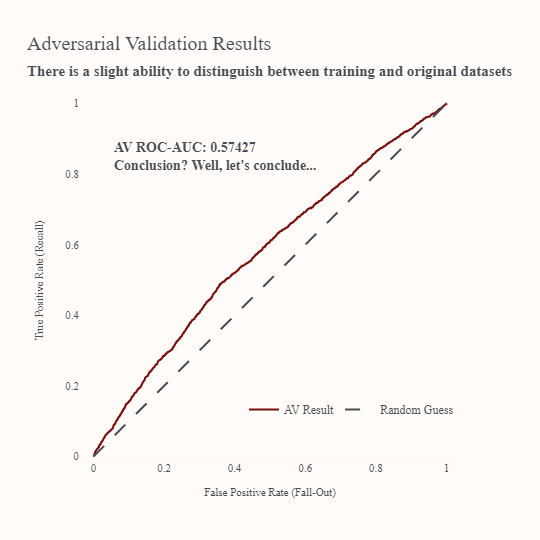

In [82]:
fig = go.Figure()
fig.add_scatter(
    x=av_scores["FPR-TPR-Threshold"][0],
    y=av_scores["FPR-TPR-Threshold"][1],
    name="AV Result",
    mode="lines",
    line_color=COLOR_SCHEME[1],
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="Random Guess",
    mode="lines",
    line=dict(dash="longdash", color=COLOR_SCHEME[0]),
)
fig.add_annotation(
    x=0.05,
    y=0.85,
    align="left",
    xanchor="left",
    text=f"<b>AV ROC-AUC: {av_scores['ROC-AUC']:.5f}<br>" "Conclusion? Well, let's conclude...",
    showarrow=False,
    font_size=14,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
)
fig.update_layout(
    title="Adversarial Validation Results<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "There is a slight ability to distinguish between training and original datasets</span>",
    width=540,
    legend=dict(y=0.1, x=1.0),
)
save_and_show_fig(fig, "adversarial_validation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Adversarial Validation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The ROC-AUC score of $0.5$ typically indicates that the classifier cannot distinguish between the two distributions and suggests that the datasets come from the same distribution. <b>With a ROC-AUC score of $0.57$, it indicates a slight ability to distinguish between the training and original datasets, but the discrimination is not strong.</b> The score is higher than the baseline of $0.5$, suggesting some difference between the distributions, but it's not a strong signal.<b> On the other hand, the result should be as it is, as we read from competition description.</b> We're likely to include original samples in training. If you're asking for training and test datasets, the result is $0.5$.
</p>

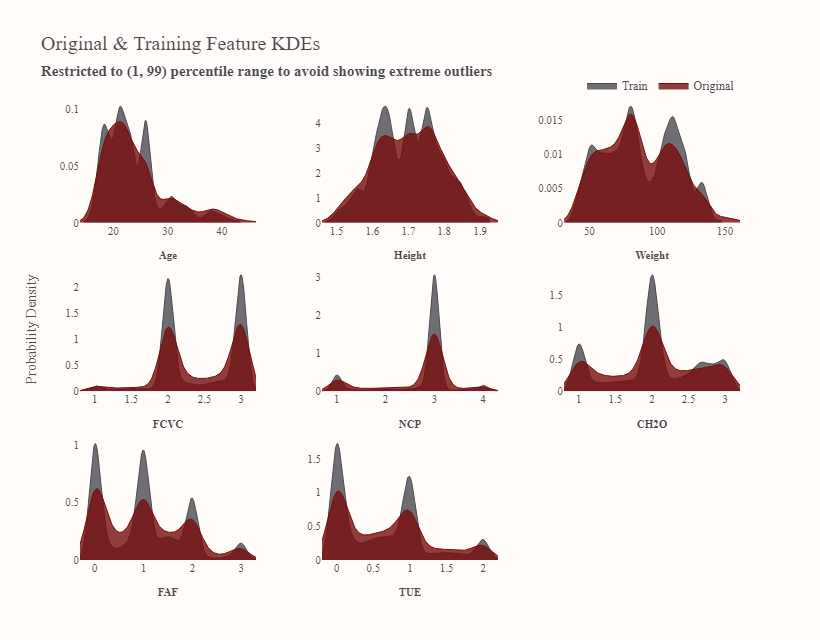

In [83]:
num_features = test.select_dtypes(include="number").columns.to_list()

n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(num_features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train, orig), COLOR_SCHEME, ("Train", "Original")):
    for k, (var, (row, col)) in enumerate(zip(num_features, axes), start=1):
        kde = get_kde_estimation(frame[var], percentile_range=(1, 99))
        fig.add_scatter(
            x=kde["space"],
            y=kde["vals"],
            line=dict(dash="solid", color=color, width=1),
            fill="tozeroy",
            fillcolor="rgba" + str((*px.colors.hex_to_rgb(color), 0.8)),
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=820,
    height=640,
    title="Original & Training Feature KDEs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to (1, 99) percentile range to avoid showing extreme outliers</span>",
)
save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Continuous Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions show why Logistic Regression was able to slightly distinguish between training and original data. As we can see, these distributions are indeed, slightly different, but in the end, it shouldn't be a problem. Alternatively we may cross-validate that. Let's continue analysis with cross tables concerning training dataset.
</p>

In [84]:
nobeyesdad_map = {
    "Insufficient_Weight": "Insufficient",
    "Normal_Weight": "Normal",
    "Obesity_Type_I": "Obesity_I",
    "Obesity_Type_II": "Obesity_II",
    "Obesity_Type_III": "Obesity_III",
    "Overweight_Level_I": "Overweight_I",
    "Overweight_Level_II": "Overweight_II",
}

for feature in num_features:
    cross = pd.crosstab(
        index=[pd.qcut(train[feature], q=5, duplicates="drop", precision=2)],
        columns=train.NObeyesdad.map(nobeyesdad_map),
        normalize="index",
    )
    stylish_frame = get_pretty_frame(cross, gradient=True, formatter="{:.1%}", repr_html=True)
    display_html(stylish_frame, raw=True)

NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
Age,,,,,,,
"(13.99, 19.0]",32.0%,27.8%,12.5%,0.2%,5.6%,12.0%,10.0%
"(19.0, 21.23]",17.7%,23.6%,9.5%,1.7%,13.5%,23.5%,10.5%
"(21.23, 23.8]",9.3%,14.0%,27.3%,10.5%,15.5%,10.5%,12.9%
"(23.8, 26.0]",0.4%,4.7%,3.4%,23.2%,61.5%,2.6%,4.2%
"(26.0, 61.0]",0.4%,3.8%,17.7%,43.5%,0.0%,10.8%,23.8%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
Height,,,,,,,
"(1.44, 1.62]",19.3%,25.7%,17.3%,1.9%,12.2%,17.6%,6.1%
"(1.62, 1.67]",4.4%,15.9%,14.6%,2.8%,47.1%,7.7%,7.5%
"(1.67, 1.73]",16.5%,13.3%,10.7%,6.1%,9.1%,15.2%,29.1%
"(1.73, 1.78]",10.8%,8.0%,9.6%,32.0%,23.7%,7.7%,8.2%
"(1.78, 1.98]",9.8%,11.3%,18.0%,35.4%,5.4%,10.3%,9.8%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
Weight,,,,,,,
"(38.99, 60.0]",59.2%,38.4%,0.1%,0.0%,0.0%,1.8%,0.5%
"(60.0, 79.71]",1.0%,34.5%,6.5%,0.2%,0.1%,42.1%,15.7%
"(79.71, 97.81]",0.0%,1.3%,40.0%,0.6%,0.1%,14.9%,43.1%
"(97.81, 112.09]",0.0%,0.0%,21.7%,15.0%,61.8%,0.0%,1.6%
"(112.09, 165.06]",0.0%,0.0%,1.8%,62.5%,35.6%,0.0%,0.0%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
FCVC,,,,,,,
"(0.99, 2.0]",10.5%,20.3%,25.1%,8.2%,0.0%,17.1%,18.9%
"(2.0, 2.94]",15.5%,0.1%,11.1%,54.7%,0.0%,9.2%,9.4%
"(2.94, 3.0]",12.6%,15.0%,3.1%,7.6%,48.9%,6.8%,5.9%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
NCP,,,,,,,
"(0.99, 2.92]",10.1%,7.0%,25.3%,17.9%,0.0%,18.6%,21.0%
"(2.92, 3.0]",9.1%,16.6%,12.0%,16.3%,26.4%,9.3%,10.2%
"(3.0, 4.0]",55.0%,18.7%,1.3%,0.9%,0.0%,17.9%,6.1%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
CH2O,,,,,,,
"(0.99, 1.48]",20.4%,20.1%,11.6%,15.1%,13.5%,10.3%,9.0%
"(1.48, 2.0]",15.0%,23.4%,13.2%,10.0%,6.1%,14.1%,18.2%
"(2.0, 2.65]",5.4%,0.0%,13.0%,35.2%,35.4%,5.6%,5.3%
"(2.65, 3.0]",4.2%,5.7%,19.1%,9.7%,38.3%,13.8%,9.1%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
FAF,,,,,,,
"(-0.01, 0.89]",10.1%,8.8%,16.3%,13.2%,32.7%,8.9%,10.0%
"(0.89, 1.0]",9.3%,26.8%,14.4%,10.8%,1.4%,18.3%,18.9%
"(1.0, 1.93]",7.3%,0.1%,7.2%,43.0%,33.0%,4.1%,5.3%
"(1.93, 3.0]",23.5%,24.4%,14.5%,4.4%,4.0%,15.5%,13.7%


NObeyesdad,Insufficient,Normal,Obesity_I,Obesity_II,Obesity_III,Overweight_I,Overweight_II
TUE,,,,,,,
"(-0.01, 0.22]",10.0%,16.5%,14.7%,21.6%,10.2%,15.2%,11.8%
"(0.22, 0.88]",4.9%,0.0%,7.3%,17.7%,58.6%,5.6%,5.9%
"(0.88, 1.0]",17.6%,27.2%,9.9%,5.1%,14.2%,10.4%,15.6%
"(1.0, 2.0]",18.7%,8.1%,29.5%,15.3%,0.2%,12.6%,15.6%


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Continuous Feature Cross Tables</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we create cross tables of each numerical feature versus the target variable. This gives us a handy univariate analysis of cut-off levels in particular variables and how target categories characterize this level. Each level is row-wise normalized, so for example, the $(13.99, 19.0]$ cut-off level in the <code>Age</code> feature is characterized by 32% observations with <code>Insufficient_Weight</code> target value. Here we have quite a lot of information, so I don't want to focus on each table. In the end, here we have synthetic data obtained from model trained on synthetic data so maybe don't pay a special attention to that. Let's see correlations now!
</p>

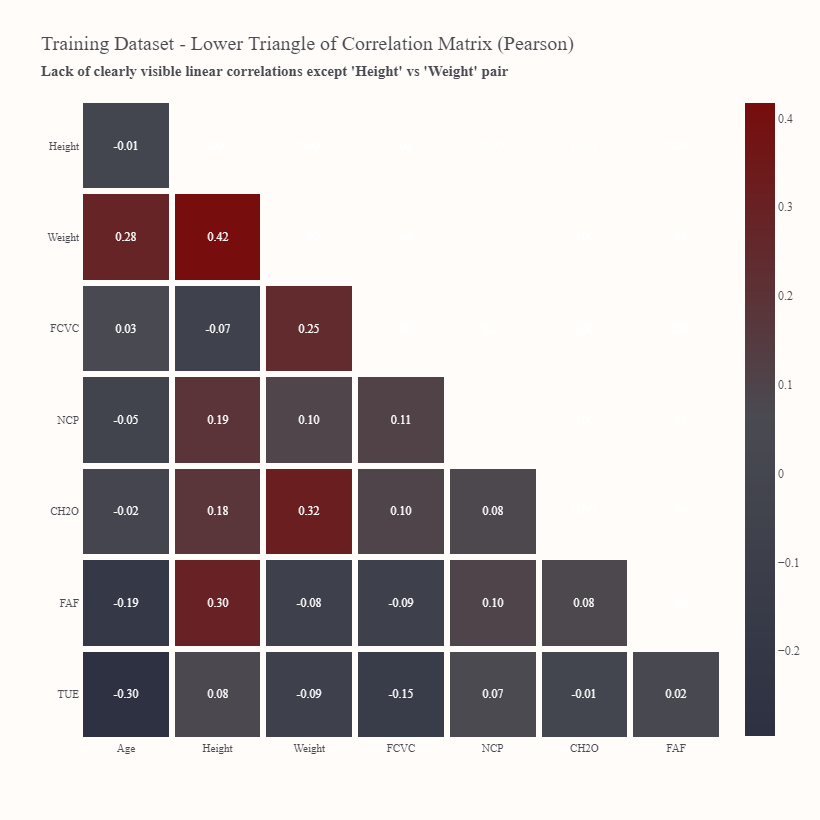

In [85]:
pearson_corr = train.corr(method="pearson", numeric_only=True)
lower_triu_corr = get_lower_triangular_frame(pearson_corr)
colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[2, 0, 1]]))

heatmap = go.Heatmap(
    z=lower_triu_corr,
    x=lower_triu_corr.columns,
    y=lower_triu_corr.index,
    text=lower_triu_corr.fillna(""),
    texttemplate="%{text:.2f}",
    xgap=6,
    ygap=6,
    showscale=True,
    colorscale=colormap,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Training Dataset - Lower Triangle of Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Lack of clearly visible linear correlations except 'Height' vs 'Weight' pair</span>",
    yaxis_autorange="reversed",
    width=820,
    height=820,
)
save_and_show_fig(fig, "pearson_corr_matrix")

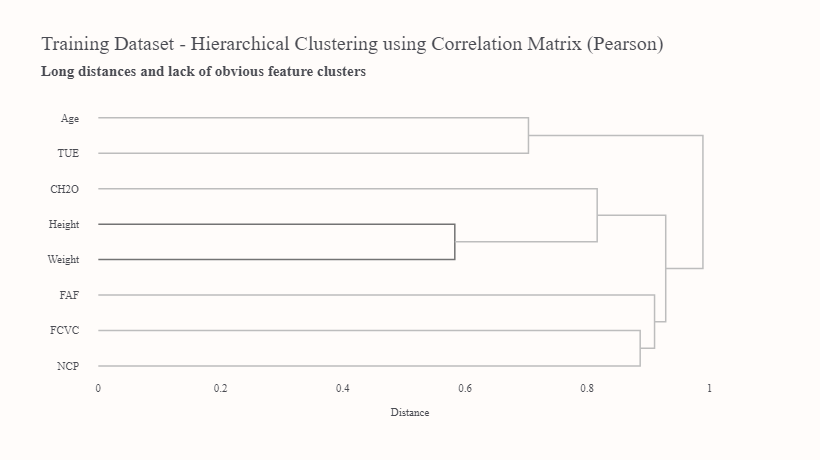

In [86]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[3:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.03, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Long distances and lack of obvious feature clusters</span>",
    height=460,
    width=820,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

In [87]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

   Feature 1 Feature 2  Absolute Pearson Correlation
0     Height    Weight                       0.41668
1     Weight      CH2O                       0.31791
2        Age       TUE                       0.29615
3     Height       FAF                       0.29528
4        Age    Weight                       0.28338
..       ...       ...                           ...
23       Age      FCVC                       0.03441
24       FAF       TUE                       0.02121
25       Age      CH2O                       0.01633
26       Age    Height                       0.01171
27      CH2O       TUE                       0.01065

[28 rows x 3 columns]


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Correlation Matrix &amp; Hierarchical Clustering</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have Pearson correlation visual analysis. As you notice, there are no clear linear correlations except somehow correlated <code>Height</code> vs <code>Weight</code> which is intuitive. You can ask about the Spearman correlation but the situation is similar to the Pearson one. As for hierarchical clustering, it's based on linear correlations, which we just use to assess whether there are feature clusters. As you can see, unfortunately, we haven't got such here since distances between variables are quite large (it's just a reflection of weak correlations). In this specific example, I've used <code>complete</code> method in <code>linkage</code> function, and if you use a different method, you get different results.<br><br> Well, correlations don't tell us much. Maybe scatter-pair plots will show more?
</p>

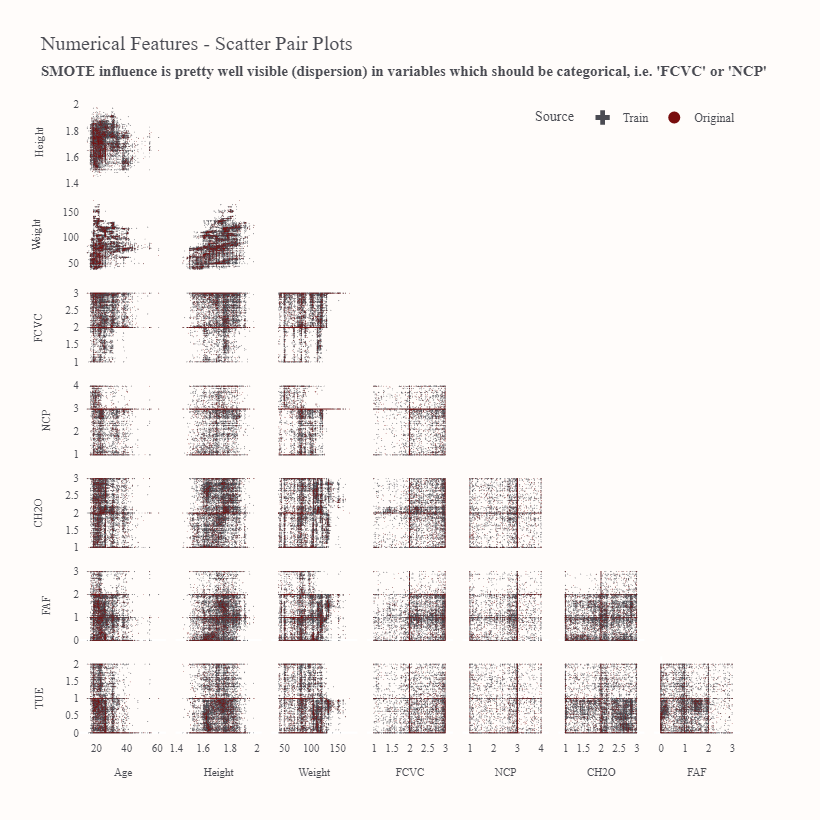

In [88]:
fig = px.scatter_matrix(
    train_extended,
    dimensions=num_features,
    color="Source",
    symbol="Source",
    symbol_sequence=("cross", "circle"),
    title="Numerical Features - Scatter Pair Plots<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "SMOTE influence is pretty well visible (dispersion) in variables "
    "which should be categorical, i.e. 'FCVC' or 'NCP'</span>",
    width=820,
    height=820,
)
fig.update_traces(diagonal_visible=False, showupperhalf=False, marker_size=0.75)
fig.update_layout(legend=dict(itemsizing="constant", y=0.95))
save_and_show_fig(fig, "scatter_pair_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Scatter-Pair Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, we can see such an interesting visualization, showing SMOTE use in the original dataset. Features like <code>FCVC</code>, <code>NCP</code>, etc. <b>in the original survey are categorical, but the synthetic method introduced some weird observations.</b> Now, let's get to the categorical features.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Playing with Categorical Variables</span></b><a class="anchor" id="playing_with_categorical_variables"></a> [↑](#top)

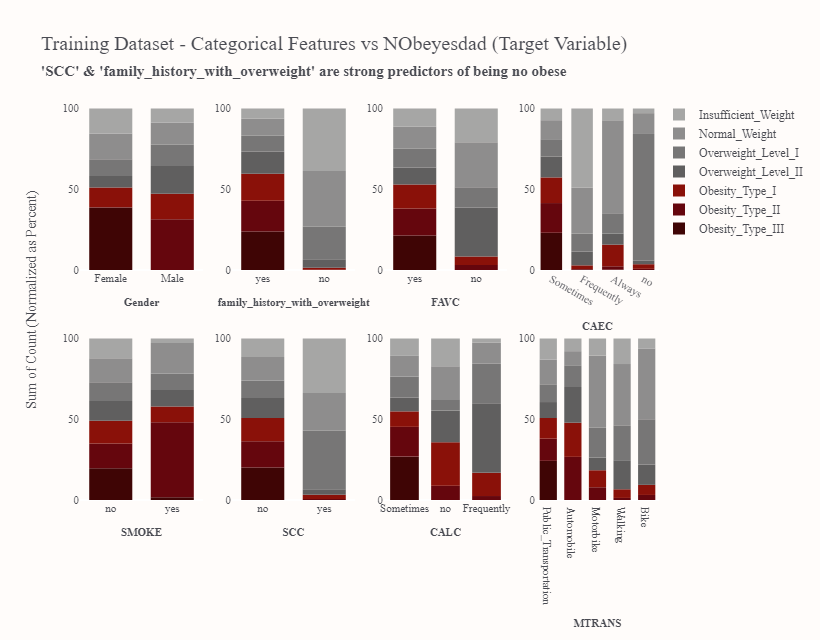

In [89]:
target_sorted = (
    "Obesity_Type_III",
    "Obesity_Type_II",
    "Obesity_Type_I",
    "Overweight_Level_II",
    "Overweight_Level_I",
    "Normal_Weight",
    "Insufficient_Weight",
)
cat_features = test.select_dtypes(exclude="number").columns.to_list()

n_cols = 4
n_rows, axes = get_n_rows_and_axes(len(cat_features), n_cols)
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Sum of Count (Normalized as Percent)",
)
fig.update_annotations(font_size=14)

for k, (var, (row, col)) in enumerate(zip(cat_features, axes), start=1):
    for outcome, color in zip(target_sorted, px.colors.diverging.oxy):
        fig.add_histogram(
            x=train.query(f"NObeyesdad == '{outcome}'")[var],
            marker_color=color,
            name=outcome,
            legendgroup=outcome,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    title="Training Dataset - Categorical Features vs NObeyesdad (Target Variable)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "'SCC' & 'family_history_with_overweight' are strong predictors of being no obese</span>",
    width=820,
    height=640,
    barnorm="percent",
    barmode="relative",
    bargap=0.3,
    legend=dict(orientation="v", xanchor="left", yanchor="top", traceorder="reversed"),
)
save_and_show_fig(fig, "categorical_bars")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Categorical Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Bar plots above are normalized as percent count so they can be easily compared across specific categories in the target variable. Let's see:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <li><code>family_history_with_overweight</code> - <b>Strong predictor of being no obese (answer 'no' concerns 18% of samples).</b></li>
    <li><code>SCC</code> - Not so strong as the <code>family_history_with_overweight</code> because this situation concerns only 3% of samples.</li>

</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    An identical situation appears in the original dataset, and there is a high probability that in the test subset too. You can analyse these plots further, for example there is no 'Obesity_Type_III' for men but its high probable for women. <b>About 39% of women across all women has 'Obesity_Type_III'. This feature is strong predictor for this specific category.</b> Let's see whether there are the same categories in all datasets.
</p>

In [90]:
check_categories_alignment(train, test, out_color=RED)

The same categories in training and test datasets?

Gender                         True
family_history_with_overweight True
FAVC                           True
CAEC                           True
SMOKE                          True
SCC                            True
CALC                           False
MTRANS                         True


In [91]:
display_html(
    get_pretty_frame(
        pd.DataFrame(
            {
                "Train": train.CALC.value_counts(),
                "Test": test.CALC.value_counts(),
                "Orig": orig.CALC.value_counts(),
            }
        ),
        precision=0,
        repr_html=True,
    ),
    raw=True,
)

,Train,Test,Orig
CALC,,,
Always,nan,2,1
Frequently,529,346,70
Sometimes,15066,9979,1401
no,5163,3513,639


In [92]:
test.CALC = test.CALC.replace({"Always": "Frequently"})
orig.CALC = orig.CALC.replace({"Always": "Frequently"})

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Category Mismatch</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    There is no 'Always' category in training dataset in <code>CALC</code> feature. As we can see there are only three such observations in test and original subsets in total. We can reject this category and map it to something more frequent, like 'Frequently'. <b>This is the only mismatch in categorical variables between available datasets.</b> Let's talk a little about correlations between categorical variables.<br><br>
    We are used to talking about correlation regarding continuous variables, but what about categorical ones? How do we measure whether two categorical features are related to each other? Generally, correlation measures the relationship between two continuous variables, and there are two main methods of calculating it. These are the Pearson correlation, which measures linear relationships and is based on actual values, and the Spearman correlation, which measures monotonic relations and is based on ranks. However, both of them have the same interpretation, i.e. $1$ means perfect positive correlation, while $-1$ means perfect negative correlation. Zero means a lack of correlation.<br><br>
    <b>When discussing categorical features, the Chi-Square Test of Independence comes into play.</b> It's a nonparametric hypothesis test, which can be used to assess whether two categorical features show a relationship. If there is a relationship, that means the probability of one variable having a specific value depends on the other variable's value. <b>The test is based on group frequencies, i.e., the number of value counts in each group and compares the observed frequencies to the frequencies you would expect if the two variables are unrelated.</b> To perform the test, we must pass a contingency table (in <code>pandas</code>, it's the output of the <code>crosstab()</code> function) to the appropriate function. Moreover, the null hypothesis here is that two variables are not associated. If the p-value is smaller than $0.05$, we can reject the null hypothesis with a $95$% level of confidence and accept the alternative hypothesis that the two variables are related. Let's get to the work using <code>chi2_contingency()</code> function from <code>scipy</code> library.
</p>

In [93]:
results = []

for var1, var2 in itertools.product(cat_features, cat_features):
    if var1 == var2:
        continue
    contingency = pd.crosstab(train[var1], train[var2])
    result = stats.chi2_contingency(contingency)
    pvalue = result.pvalue  # type: ignore
    results.append((var1, var2, pvalue))

related_vars = pd.DataFrame(results, columns=["var1", "var2", "pvalue"])
min_ids = related_vars.groupby("var1")["pvalue"].idxmin()
related_vars = related_vars.iloc[min_ids, :2].to_numpy()

print(CLR + "Most Related Categorical Pairs:\n")
for var1, var2 in related_vars:
    print(CLR + f"{var1:35s}", CLR + var2)


Most Related Categorical Pairs:

CAEC                                family_history_with_overweight
CALC                                CAEC
FAVC                                family_history_with_overweight
Gender                              MTRANS
MTRANS                              Gender
SCC                                 family_history_with_overweight
SMOKE                               Gender
family_history_with_overweight      CAEC


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Most Related Categorical Variables</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, we see which feature has the strongest relation with the second one. For example, the <code>Gender</code> is related to the <code>MTRANS</code> the most and vice versa, and there is no coincidence because when you look at the contingency table, you will see that men more often use automobile whereas women use public communication. 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.4</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Probability Plots &amp; Example Transformations</span></b><a class="anchor" id="probability_plots_and_example_transformations"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This subsection focuses on the exploration of probability plots, which are a graphical technique used to determine if a variable adheres to a particular distribution, specifically the normal distribution in this case. <b>Probability plots display samples that follow a normal distribution along a straight diagonal line.</b> Some machine learning models make the assumption that variables follow a normal distribution. Consequently, the mentioned technique assists in determining the necessary transformations to improve the variable's alignment with that distribution. We will begin with examining the original values and observing the outcomes.
</p>

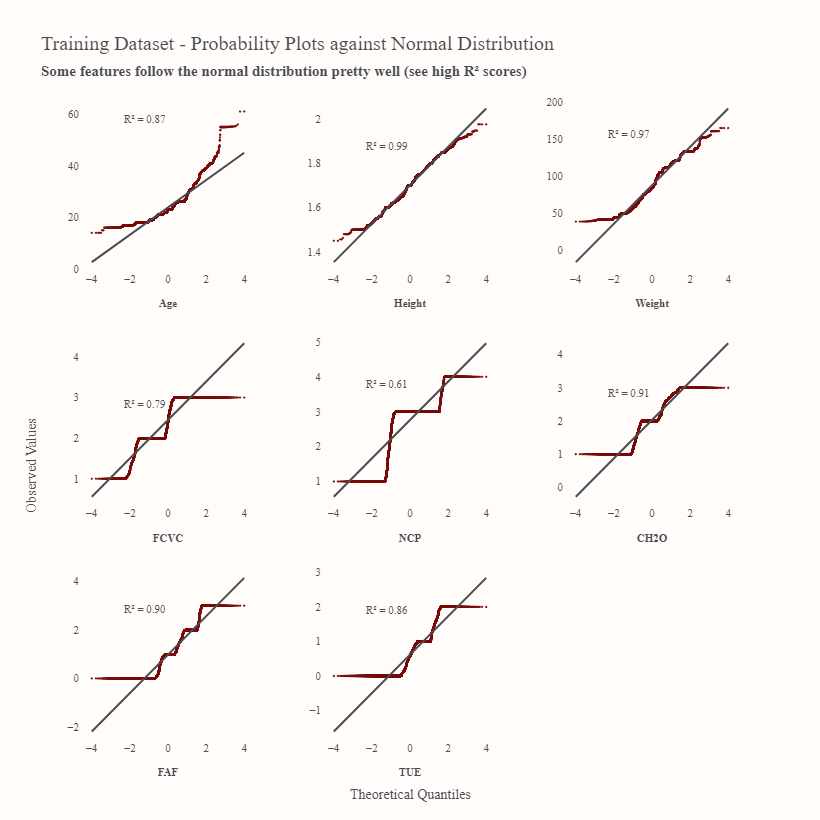

In [94]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(num_features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Observed Values",
    x_title="Theoretical Quantiles",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, num_features):
    (osm, osr), (slope, intercept, R) = stats.probplot(train[feature].dropna(), rvalue=True)
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row, col=col, name=feature)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row, col=col)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.95,
        text=R2,
        showarrow=False,
        row=row,
        col=col,
        font_size=11,
    )
    fig.update_xaxes(title_text=f"<b>{feature}</b>", row=row, col=col)

fig.update_layout(
    title="Training Dataset - Probability Plots against Normal Distribution<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Some features follow the normal distribution pretty well (see high R\u00b2 scores)</span>",
    width=820,
    height=820,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[1])),
    line_color=COLOR_SCHEME[0],
)
save_and_show_fig(fig, "probability_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Probability Plots against Normal Distribution</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The charts are what I would expect since only three variables are truly numerical. <b>Some variables, i.e.</b> <code>Height</code>, <code>Weight</code> <b>fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line.</b> However, there are same of features which have a poor fit. We can improve that through specific transformations. Mostly used transformations are log-level and square-root ones. These work fine with right-skewed data and help to reduce the impact of outliers. Another transformation is, for example, a reciprocal one, which is sometimes used when data is skewed, or there are obvious outliers. More sophisticated methods are Box-Cox transformation (requires strictly positive numbers) and Yeo-Johnson (variation of Box-Cox), which has no restrictions concerning numbers.<br><br>
    <b>In this specific case we don't have a chance to improve distributions' fit but it's good to see these plots.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.5</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">BMI is not Sufficient due to its Synthetic Nature</span></b><a class="anchor" id="bmi_is_not_sufficient_due_to_its_synthetic_nature"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The first thought is, <b>"If we have height and weight and have to calculate obesity levels, does the BMI shouldn't give 100% results?"</b> Well, it should, but one needs to remember that data is synthetically generated, and the original work is in 77%, too. Let's check this. First, we need to reveal two levels of overweight because normally there is only one level, $25-29.9$. To do this, we will use real data from the original dataset. <b>As we can read in the original paper, there are 485 real samples.</b> As it happens, these are the first observations of the original data frame.
</p>

In [95]:
get_pretty_frame(
    orig.iloc[:485]
    .assign(BMI=orig.iloc[:485].Weight / (orig.iloc[:485].Height ** 2))  # type: ignore
    .groupby("NObeyesdad")
    .agg(("min", "max"))  # type: ignore
    .BMI.sort_values(by="max")
)

,min,max
NObeyesdad,,
Insufficient_Weight,13.292,18.424
Normal_Weight,18.491,24.913
Overweight_Level_I,25.076,26.892
Overweight_Level_II,26.990,29.938
Obesity_Type_I,30.110,34.894
Obesity_Type_II,35.003,39.258
Obesity_Type_III,40.645,49.472


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Real Overweight Levels</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As you can see, these level ranges seem to be authentic. Each successive one is larger than the previous one and does not fall into smaller ranges. The 'Overweight_Level_I' is somehow $25.0-27.0$ and the 'Overweight_Level_II' is about $27.0-30.0$. Now let's validate what accuracy we get using only BMI for the entire original data frame.
</p>

In [96]:
BMI = orig.Weight / (orig.Height**2)
conditions = (
    BMI < 18.5,
    (BMI >= 18.5) & (BMI < 25.0),
    (BMI >= 25.0) & (BMI < 27.0),
    (BMI >= 27.0) & (BMI < 30.0),
    (BMI >= 30.0) & (BMI < 35.0),
    (BMI >= 35.0) & (BMI < 40.0),
    BMI >= 40.0,
)
choices = (
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
)

orig_category = np.select(conditions, choices)
print(CLR + "Accuracy: ", RED + f"{np.mean(orig_category == orig.NObeyesdad):.2f}")

Accuracy:  0.94


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Original Data Frame Accuracy</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, it works pretty well; we got 94% accuracy. The reason for not obtaining 100% is SMOTE use in the original work. However, that's still decent results and it seems that SMOTE didn't corrupt the dataset very much. Now, let's have a look at the training dataset obtained from a deep-learning model.
</p>

In [97]:
BMI = train.Weight / (train.Height**2)
conditions = (
    BMI < 18.5,
    (BMI >= 18.5) & (BMI < 25.0),
    (BMI >= 25.0) & (BMI < 27.0),
    (BMI >= 27.0) & (BMI < 30.0),
    (BMI >= 30.0) & (BMI < 35.0),
    (BMI >= 35.0) & (BMI < 40.0),
    BMI >= 40.0,
)
train_category = np.select(conditions, choices)
print(CLR + "Accuracy: ", RED + f"{np.mean(train_category == train.NObeyesdad):.2f}")

Accuracy:  0.78


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Training Data Frame Accuracy</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Only 78% of accuracy, whereas people on public LB are able to get 92%. <b>It's a poor result, and below you will see why.</b>
</p>

In [98]:
get_pretty_frame(
    train.assign(BMI=train.Weight / (train.Height**2))  # type: ignore
    .groupby("NObeyesdad")
    .agg(("min", "max"))  # type: ignore
    .BMI.sort_values(by="max")
)

,min,max
NObeyesdad,,
Normal_Weight,14.632,32.882
Overweight_Level_I,15.762,35.556
Overweight_Level_II,21.514,36.741
Insufficient_Weight,12.869,36.778
Obesity_Type_II,24.048,46.222
Obesity_Type_I,16.597,46.805
Obesity_Type_III,18.179,54.998


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #780D0D;
">
    <b>Complete Mismatch</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here is a complete mismatch; for example, the minimal value of 'Obesity_Type_III' is around $18$, which normally denotes underweight. <b>Now it's clear why to use machine learning model. It must learn these weird patterns.</b>
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Unsupervised Learning &amp; Methods</span></b><a class="anchor" id="unsupervised_learning_and_methods"></a> [↑](#top)